# Camera calibration and 3D reconstruction
## Camera calibration
### Basics
Some pinhole cameras introduce significant distortion to images. Two major kinds of distortion are radial distortion and tangential distortion.  
Radial distortion, which causes straight lines to appear curved, can be represented as follows:
$$
    x_{distorted} = x(1 + k_1r^2+k_2r^4+k_3r^6) \\
    y_{distorted} = y(1+k_1r^2+k_2r^4+k_3r^6)
$$
Tangential distortion, which change some areas in the image to appear nearer than expected, can be represented as below:
$$
    x_{distorted} = x+[2p_1xy+p_2(r^2+2x^2] \\
    y_{distorted} = y+[p_1(r^2+2y^2)+2p_2xy]
$$
Distortion coefficents $(k_1, k_2, p_1, p_2, p_3)$ should be estimated. In addition to this, intrinsic and extrinsic parameters of the camera are needed. Intrinsic parameters include information like focal length $(f_x, f_y)$ and optical centers $(c_x, c_y)$. Camera matrix consists of them.
$$
camera~matrix = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$
Extrinsic parameters corresponds to rotation and translation vectors.

Some sample images of a well defined pattern should be provided to find the parameters. Known coordinates of specific points in real world space and in the image are to solve for the distortion coefficients. At least 10 test patterns are needed for good results.

### code
`cv2.findChessboardCorners(image, size, corners)` ca be used to detect pattern in chess board. It returns retval, which will be True if pattern is obtained and the corner points.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# preapre object points like (0, 0, 0), (1, 0, 0), ... (6, 5, 0)
objp = np.zeros((6 * 7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)

# arrays to store object points and image points from all the images
objpoints = []  # 3d points in real world
imgpoints = []  # 2d points in image plane

images = glob.glob('inputs/chessboards/*.jpeg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7, 6), None)
    
    # if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (7, 6), corners2, ret)
        cv2.startWindowThread()  # This line is not needed when you execute from terminal.
        cv2.imshow('img', img)
        cv2.waitKey(1000)
        
cv2.waitKey(1)  # This line is not needed when you execute from terminal.
cv2.destroyAllWindows()
cv2.waitKey(1)  # This line is not needed when you execute from terminal.

-1

### calibration
Object points and image points are obtained, let's calibrate with `cv2.calibrateCamera(objPoints, imgPoints, img)`. It returns camera matrix, distrortion parameters, rotation vectors, and translation vectors.

In [11]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
np.savez('B.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

### Undistortion
Camera matrix is improved and undistort in two ways.

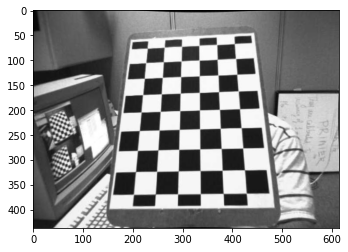

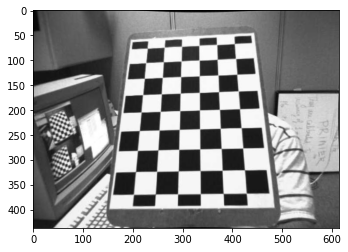

In [8]:
img = cv2.imread('inputs/chessboards/left12.jpeg')
height, width = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width, height), 1, (width, height))

# use cv2.distort()
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
col, row, width, height = roi
dst = dst[row:row+height, col:col+width]

plt.imshow(dst, "gray")
plt.show()

# use cv2.remap
height, width = img.shape[:2]
mapX, mapY = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (width, height), 5)
dst = cv2.remap(img, mapX, mapY, cv2.INTER_LINEAR)
col, row, width, height = roi
dst = dst[row:row+height, col:col+width]

plt.imshow(dst, "gray")
plt.show()


### Re-projection error
Given the intrinsic, distortion, rotation and translation matrices, `cv2.projectPoints()` reprojects the first object point to image space. Then, the absolute norm between the reprojected points and the detected points are calculated. Smaller arithmetical mean of the errors means better calibration.

In [9]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error
    
print("total_error: ", mean_error / len(objpoints))

total_error:  0.023685996975391924


## Pose estimation
This section try to create some 3D effects in images. Given a pattern image, we can utilize the aboce information to calculate its pose.

In [26]:
# load previously saved data
with np.load('B.npz') as npz:
    mtx, dist, _, _ = [npz[i] for i in ('mtx', 'dist', 'rvecs', 'tvecs')] 

# define a function which takes the corners in the chessboard and axis points to draw a 3D axis
def draw(img, corners, imgpts):
    corner = tuple(map(int, corners[0].ravel()))
    imgpts0 = tuple(map(int, imgpts[0].ravel()))
    imgpts1 = tuple(map(int, imgpts[1].ravel()))
    imgpts2 = tuple(map(int, imgpts[2].ravel()))
    
    img = cv2.line(img, corner, imgpts0, (255, 0, 0), 5)
    img = cv2.line(img, corner, imgpts1, (0, 255, 0), 5)
    img = cv2.line(img, corner, imgpts2, (0, 0, 255), 5)
    return img

# termination criteria, object points, and axis points are created.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)

# negative Z denotes it is drawn towards the camera
axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3)

# read images and detect 7 x 6 pattern
for fname in glob.glob('inputs/chessboards/*.jpeg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 6), None)
    
    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # find the rotation and translation vectors
        ret, rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        
        img = draw(img, corners2, imgpts)
        cv2.startWindowThread()  # This line is not needed when you execute from terminal.
        cv2.imshow("img", img)
        cv2.waitKey(1000)
        
#         key = cv2.waitKey(0) & 0xff
#         if key == ord('s'):
#             cv2.imwrite('outputs/' + fname[:6]+'.png', img)
            
cv2.waitKey(1)  # This line is not needed when you execute from terminal.
cv2.destroyAllWindows()
cv2.waitKey(1)  # This line is not needed when you execute from terminal.

-1

### render a cube
modify `draw()` function and axis points as follows to draw a cube

In [25]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)
    
    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)
        
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)
    
    return img

axis = np.float32([[0, 0, 0], [0, 3, 0], [3, 3, 0], [3, 0, 0],
                               [0, 0, -3], [0, 3, -3], [3, 3, -3], [3, 0, -3]])

## Epipolar geometry
### Basic concepts
Using more than one camera enable to find the depth information. We can triangulate the correct 3D point with two images.
The projection of the different points on a line form another line on another plane, it is called epiline. To find the matching point in other image, searching should be done along the epiline. This is called epipolar constraint and it eases computational cost. One camera center can be seen as a point on another plane, it is called epipole.  
Here, we focus on finding epipolar lines and epipoles.

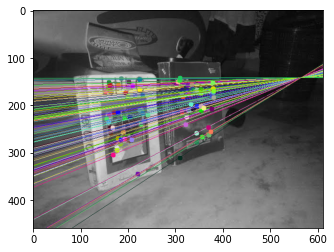

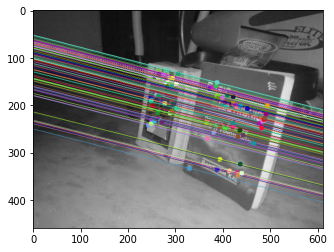

In [28]:
img1 = cv2.imread('inputs/left.jpeg', 0)
img2 = cv2.imread('inputs/right.jpeg', 0)

sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# point matching
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
# find the Fundamental Matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

# select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


# function to draw the epilines
def drawlines(img1, img2, lines, pts1, pts2):
    rows, cols = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for rows, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -rows[2] / rows[1]])
        x1, y1 = map(int, [cols, -(rows[2]+rows[0]*cols) / rows[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    
    return img1, img2

# find epilines corresponding to points in second image and drawing its lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, fundamental)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# find epilines corresponding to points in first image and drawing its lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, fundamental)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.imshow(img5)
plt.show()

plt.imshow(img3)
plt.show()

## Depth map from stereo images
### Basics
If the distance between two cameras $B$ and the focal length of camera $f$ are known, the relation between the disparity $d$ and the depth $Z$ is written as:
$$
d = \frac{Bf}{Z}
$$
This information helps to derive the depth of all pixels in an image.

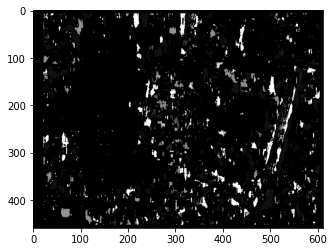

In [29]:
imgL = cv2.imread('inputs/left.jpeg', 0)
imgR = cv2.imread('inputs/right.jpeg', 0)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity, 'gray')
plt.show()